In [38]:
#####Von Mises Regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [46]:
####データの発生####
##データの設定
k = 10
N = 100000

##説明変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = x.shape[1]

(array([ 9396.,  2725.,   813.,   530.,   856.,  2629.,  8850., 21013.,
        30245., 22943.]),
 array([-3.14154057e+00, -2.51322756e+00, -1.88491455e+00, -1.25660154e+00,
        -6.28288531e-01,  2.44796370e-05,  6.28337490e-01,  1.25665050e+00,
         1.88496351e+00,  2.51327652e+00,  3.14158953e+00]),
 <a list of 10 Patch objects>)

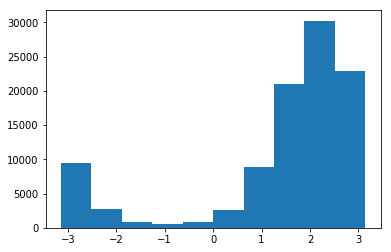

In [47]:
##応答変数の生成
#パラメータの設定
beta0 = np.random.uniform(0.75, 1.5, 1)
beta1 = np.random.normal(0, 0.75, k-1)
beta = np.append(beta0, beta1)
kappa = np.random.uniform(2.0, 4.0, 1)
betat = beta.copy(); kappat = kappa.copy()

#フォンミーゼス分布から円周データを生成
mu = 2*np.arctan(np.dot(x, beta))
y = np.random.vonmises(mu, kappa, N)
plt.hist(y)

In [48]:
##Von Mises Regression modelのパラメータを推定するための関数
#Von Mises Regression modelの対数尤度関数
def loglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])
    
    #対数尤度の和を計算
    mu = 2*np.arctan(np.dot(x, beta))
    LL = -N*np.log(2*np.pi*scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return -LL

In [49]:
#Von Mises Regression modelの対数尤度関数の勾配ベクトル
def dloglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])

    #回帰ベクトルの対数尤度の勾配ベクトル
    beta_mu = np.dot(x, beta)
    mu = 2*np.arctan(beta_mu)
    LLd1 = np.sum(kappa * (np.sin(y - mu).reshape(N, 1)) * (2 * (x / (1 + np.power(beta_mu.reshape(N, 1), 2)))), axis=0)
    
    #分散パラメータの対数尤度の勾配
    h = 1e-4
    LLd2 = (LL_kappa(kappa+h, mu, y, x, N) - LL_kappa(kappa-h, mu, y, x, N)) / (2*h)
    
    #勾配ベクトルの戻り値
    LLd = -np.append(LLd1, LLd2)
    return LLd

In [50]:
#分散パラメータの推定用の対数尤度関数
def LL_kappa(kappa, mu, y, x, N):
    LL = -N*np.log(2*np.pi*scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return LL 

In [53]:
##準ニュートン法で対数尤度を最大化
while True:
    #初期値の設定
    index1 = np.arange(k); index2 = k
    beta = np.append(1, np.random.normal(0, 0.25, k-1))
    kappa = np.random.uniform(0, 1.0, 1)
    theta = np.append(beta, kappa)

    #対数尤度を最大化
    res = optimize.minimize(loglike, theta, jac=dloglike, method='BFGS', args=(y, x, N, index1, index2), 
                            options={"gtol": 0.1, "disp":False})
    if res.success==True:
        break

In [54]:
##推定されたパラメータの確認と適合度
#推定されたパラメータと真のパラメータの比較
theta = res.x   #推定されたパラメータ
hessian = res.hess_inv   #ヘッシアンの逆行列
LL = -res.fun   #最大化された対数尤度
LLbest = -loglike(np.append(betat, np.log(kappat)), y, x, N, index1, index2)   #真値での対数尤度
print(np.round(np.array([LL, LLbest]), 3))
print(np.round(np.array([theta[index1], betat]), 3))
print(np.round(np.array([np.exp(theta[index2]), kappat]), 3))

[-121609.093 -121617.259]
[[ 1.421 -0.056  0.385 -0.41   0.497  0.956 -0.02  -0.27   0.245 -0.077
  -0.406  0.8    0.224 -0.253  1.26 ]
 [ 1.347 -0.045  0.374 -0.399  0.524  0.979 -0.027 -0.268  0.255 -0.083
  -0.354  0.866  0.276 -0.186  1.293]]
[2.157 2.162]


In [9]:
#適合度の確認
t_value = theta / np.sqrt(np.diag(hessian))   #t値
AIC = -2*LL + 2*(k+1)   #AIC
BIC = -2*LL + np.log(N)*(k+1)   #BIC
print(np.round(t_value, 3))
print(np.round(np.array([LL, AIC, BIC]), 3))

[  72.312  -39.05   -28.038   82.472  -91.229   90.668  153.926   62.975
  120.813 -161.963   42.029   29.607   23.531    5.656  -49.402  159.329]
[-100182.936  200397.872  200550.079]
